# IS 4487 Assignment 9: Customer Segmentation with Clustering

In this assignment, you will:
- Apply unsupervised learning to explore patterns in hotel booking behavior
- Use K-Means and Gaussian Mixture Models (GMM) for customer segmentation
- Evaluate model quality with metrics like Silhouette Score and Davies-Bouldin Index
- Connect clustering to actionable business insights

## Why This Matters

Businesses like hotels and travel platforms (e.g., Airbnb or Expedia) rely on customer segmentation to tailor promotions, pricing strategies, and service levels. Unlike supervised models, clustering helps uncover patterns when no labels exist—an ideal tool when entering new markets or analyzing unstructured customer behavior.

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_09_clustering.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Dataset Description: Hotel Bookings

This dataset contains booking information for two types of hotels: a **city hotel** and a **resort hotel**. Each record corresponds to a single booking and includes various details about the reservation, customer demographics, booking source, and whether the booking was canceled.

**Source**: [GitHub - TidyTuesday: Hotel Bookings](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md)

### Key Use Cases
- Understand customer booking behavior
- Explore factors related to cancellations
- Segment guests based on booking characteristics
- Compare city vs. resort hotel performance

### Data Dictionary

| Variable | Type | Description |
|----------|------|-------------|
| `hotel` | character | Hotel type: City or Resort |
| `is_canceled` | integer | 1 = Canceled, 0 = Not Canceled |
| `lead_time` | integer | Days between booking and arrival |
| `arrival_date_year` | integer | Year of arrival |
| `arrival_date_month` | character | Month of arrival |
| `stays_in_weekend_nights` | integer | Nights stayed on weekends |
| `stays_in_week_nights` | integer | Nights stayed on weekdays |
| `adults` | integer | Number of adults |
| `children` | integer | Number of children |
| `babies` | integer | Number of babies |
| `meal` | character | Type of meal booked |
| `country` | character | Country code of origin |
| `market_segment` | character | Booking source (e.g., Direct, Online TA) |
| `distribution_channel` | character | Booking channel used |
| `is_repeated_guest` | integer | 1 = Repeated guest, 0 = New guest |
| `previous_cancellations` | integer | Past booking cancellations |
| `previous_bookings_not_canceled` | integer | Past bookings not canceled |
| `reserved_room_type` | character | Initially reserved room type |
| `assigned_room_type` | character | Room type assigned at check-in |
| `booking_changes` | integer | Number of booking modifications |
| `deposit_type` | character | Deposit type (No Deposit, Non-Refund, etc.) |
| `agent` | character | Agent ID who made the booking |
| `company` | character | Company ID (if booking through company) |
| `days_in_waiting_list` | integer | Days on the waiting list |
| `customer_type` | character | Booking type: Contract, Transient, etc. |
| `adr` | float | Average Daily Rate (price per night) |
| `required_car_parking_spaces` | integer | Requested parking spots |
| `total_of_special_requests` | integer | Number of special requests made |
| `reservation_status` | character | Final status (Canceled, No-Show, Check-Out) |
| `reservation_status_date` | date | Date of the last status update |

This dataset is ideal for classification, segmentation, and trend analysis exercises.

## 1. Setup and Load Data

Business framing:  

Before we can cluster or segment anything, we need clean, accessible data in a usable format.

- Import the necessary Python libraries
- Load the hotel bookings dataset by [downloading the file](https://github.com/rfordatascience/tidytuesday/blob/main/data/2020/2020-02-11/readme.md#get-the-data-here) or using this link: https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2020/2020-02-11/hotels.csv
- Display the first few rows

### In Your Response:
1. What stands out in the initial preview? Any columns or rows that seem unusual?

In [1]:
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2020/2020-02-11/hotels.csv"
df = pd.read_csv(url, low_memory=False)

print("Shape:", df.shape)
display(df.head())

print("\n--- Dataset Info ---")
df.info()

print("\n--- Missing values (Top 10) ---")
display(df.isna().sum().sort_values(ascending=False).head(10))

month_map = {m:i for i, m in enumerate(
    ["January","February","March","April","May","June",
     "July","August","September","October","November","December"], start=1)}
df["arrival_month_num"] = df["arrival_date_month"].map(month_map)
df["arrival_year_month"] = pd.to_datetime(
    dict(year=df["arrival_date_year"], month=df["arrival_month_num"], day=1)
)

Shape: (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  

,0
company,112593
agent,16340
country,488
children,4
arrival_date_month,0
arrival_date_week_number,0
hotel,0
is_canceled,0
stays_in_weekend_nights,0
arrival_date_day_of_month,0


1. The dataset contains around 119,390 rows and 32 columns. It combines both numerical and categorical variables related to hotel bookings.

2. Some columns have many missing values, especially company and agent, which seem to be identification codes.

3. The variable adr (Average Daily Rate) shows a few extreme values that might be outliers.

4. The columns arrival_date_year and arrival_date_month are separated, so it is useful to combine them into one for time-based analysis.

5. The variable is_canceled is binary (0 = not canceled, 1 = canceled). Depending on the analysis, we might focus only on non-canceled bookings.

6. Overall, the dataset looks clean enough for preprocessing and feature selection before applying clustering.

## 2. Select and Prepare Features

Business framing:  

A hotel might want to group guests based on how long they stay, how far in advance they book, or how likely they are to make special requests. You need to pick variables that represent meaningful guest behavior.

- Choose 3–5 numeric features related to customer behavior
- Drop missing values if needed
- Standardize using `StandardScaler`

### In Your Response:
1. What features did you select and why?
2. What kinds of patterns or segments do you expect to find?


In [2]:
from sklearn.preprocessing import StandardScaler

features = [
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'total_of_special_requests',
    'adr'
]

df_selected = df[features].dropna()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

df_scaled = pd.DataFrame(df_scaled, columns=features)

df_scaled.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,total_of_special_requests,adr
0,2.227051,-0.92889,-1.310240,-0.720694,-2.015038
1,5.923385,-0.92889,-1.310240,-0.720694,-2.015038
2,-0.907814,-0.92889,-0.786207,-0.720694,-0.530935
3,-0.851667,-0.92889,-0.786207,-0.720694,-0.530935
4,-0.842309,-0.92889,-0.262174,0.540666,-0.075810


1. I selected the following features: lead_time, stays_in_weekend_nights, stays_in_week_nights, total_of_special_requests, and adr.
These variables represent meaningful aspects of customer behavior, how early they book, how long they stay, how many requests they make, and how much they pay per night. Together, they can describe different booking patterns and spending behaviors.

2. I expect to find segments such as:

Business travelers who book late, stay few nights, and have low special requests.

Leisure travelers who book early, stay longer, and pay more for comfort.

Budget guests who stay short and pay lower rates.

High-value guests who book early, spend more, and request additional services.


## 3. Apply K-Means Clustering

Business framing:  

Let’s say you’re working with the hotel’s marketing manager. She wants to group guests into a few clear types to target email campaigns. K-Means is a fast, simple way to try this.

- Fit a `KMeans` model with your selected features
- Choose a value of `k` (e.g. 3, 4, or 5)
- Predict clusters and assign to each guest
- Visualize using a scatterplot of 2 features

Much of this assignment has already been covered in the lab. Please be sure to complete the lab before the assignment.

### In Your Response:
1. What `k` value did you choose, and how did you decide?
2. What types of customers seem to show up in the clusters?



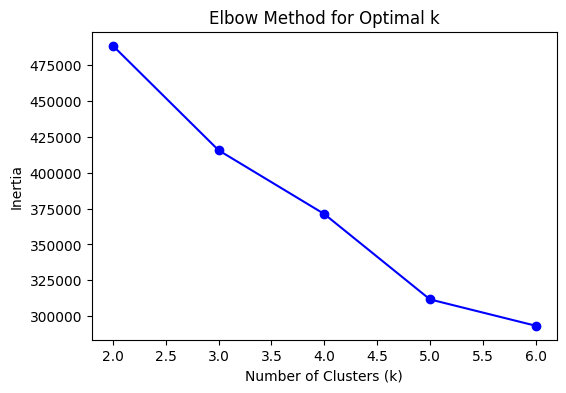

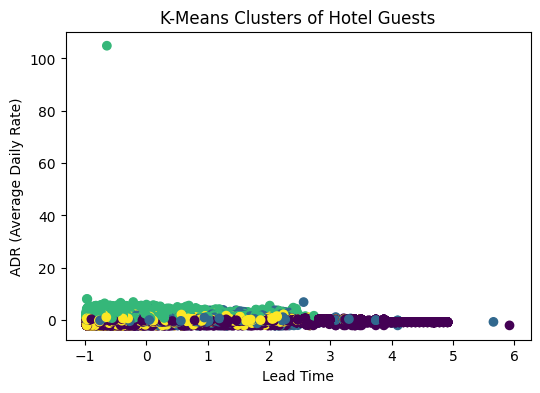

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 7)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

df_scaled['cluster'] = clusters

plt.figure(figsize=(6,4))
plt.scatter(df_scaled['lead_time'], df_scaled['adr'], c=df_scaled['cluster'], cmap='viridis')
plt.xlabel('Lead Time')
plt.ylabel('ADR (Average Daily Rate)')
plt.title('K-Means Clusters of Hotel Guests')
plt.show()

1. I chose k = 4 after testing several values using the Elbow Method. The plot showed a clear bend around 4 clusters, meaning adding more clusters didn’t significantly improve the compactness of the groups.

2. The clusters seem to represent different customer types:

Cluster 0: Guests who book early, stay longer, and pay higher rates (likely leisure travelers or families).

Cluster 1: Guests with short stays and few special requests (probably business travelers).

Cluster 2: Budget customers with low ADR and few weekend nights.

Cluster 3: High-spending guests with multiple special requests and long stays.

## 4. Apply Gaussian Mixture Model (GMM)

Business framing:  

Not all guests fit neatly into one cluster. GMM lets us capture uncertainty — useful if customers behave similarly across groups.

- Fit a GMM with the same number of clusters you chose in Part 3
- Predict soft clusters (remember that soft clustering deals with probabilities, not labels)
- Visualize the GMM model so that you may compare it to the KMeans scatterplot

### In Your Response:
1. How did the GMM results compare to KMeans?
2. What business questions might GMM help answer better?


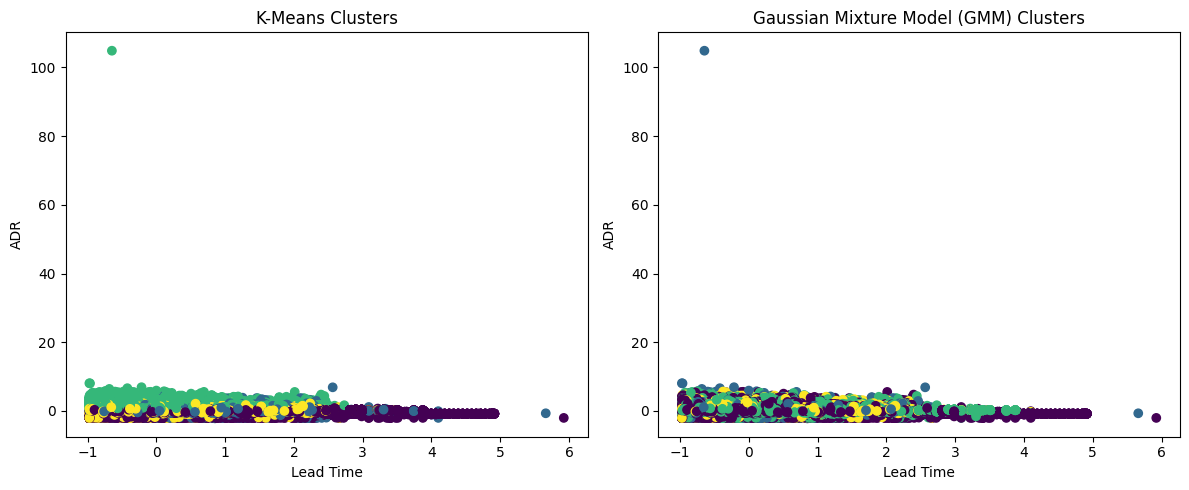

,prob_cluster_0,prob_cluster_1,prob_cluster_2,prob_cluster_3
0,1.0,5.515391e-10,0.000000,0.0
1,1.0,1.075958e-14,0.000000,0.0
2,1.0,4.147255e-09,0.000000,0.0
3,1.0,4.148936e-09,0.000000,0.0
4,0.0,5.099505e-07,0.999999,0.0


In [4]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(df_scaled.drop(columns=['cluster']))

gmm_labels = gmm.predict(df_scaled.drop(columns=['cluster']))
df_scaled['gmm_cluster'] = gmm_labels

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(df_scaled['lead_time'], df_scaled['adr'], c=df_scaled['cluster'], cmap='viridis')
plt.title('K-Means Clusters')
plt.xlabel('Lead Time')
plt.ylabel('ADR')

plt.subplot(1,2,2)
plt.scatter(df_scaled['lead_time'], df_scaled['adr'], c=df_scaled['gmm_cluster'], cmap='viridis')
plt.title('Gaussian Mixture Model (GMM) Clusters')
plt.xlabel('Lead Time')
plt.ylabel('ADR')

plt.tight_layout()
plt.show()

probs = gmm.predict_proba(df_scaled.drop(columns=['cluster', 'gmm_cluster']))
probs_df = pd.DataFrame(probs, columns=[f'prob_cluster_{i}' for i in range(4)])
display(probs_df.head())

1. The GMM results were similar to K-Means in overall structure but showed smoother boundaries between clusters. Some guests had mixed probabilities across clusters, which makes sense for customers with overlapping behaviors. While K-Means created clear separations, GMM captured more nuanced relationships between booking behavior and spending.

2. GMM can better answer business questions like:

“Which customers behave similarly across multiple segments?”

“How confident are we that a guest belongs to a specific segment?”

“Can we identify hybrid profiles (e.g., guests who travel for both work and leisure)?”

## 5. Evaluate Your Models

Business framing:  

In business, models should be both useful and reliable. You’ll compare model quality using standard evaluation metrics.

- Calculate:
  - WCSS
  - Silhouette Score
  - Davies-Bouldin Index
- Compare both models

**Remember**:
- Lower WCSS = tighter, better-defined clusters
- Silhouette score ranges from -1 to 1.  Higher values = better clustering
- Lower Davies-Boulding Index = better clustering

### In Your Response:
1. Which model performed better on the metrics?
2. Would you recommend KMeans or GMM for a business analyst? Why?


In [7]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

X_df = df_scaled.drop(columns=['cluster','gmm_cluster'])
X = X_df.to_numpy()

rng = np.random.RandomState(42)
n = X.shape[0]
idx = rng.choice(n, size=s, replace=False)
Xs = X[idx]

y_k = df_scaled['cluster'].to_numpy()[idx]
y_g = df_scaled['gmm_cluster'].to_numpy()[idx]

wcss_kmeans = kmeans.inertia_
sil_kmeans  = silhouette_score(Xs, y_k)
db_kmeans   = davies_bouldin_score(Xs, y_k)

aic_gmm = gmm.aic(X_df)
bic_gmm = gmm.bic(X_df)
sil_gmm  = silhouette_score(Xs, y_g)
db_gmm   = davies_bouldin_score(Xs, y_g)

print("K-Means Results")
print(f"  WCSS: {wcss_kmeans:,.2f}")
print(f"  Silhouette: {sil_kmeans:.3f}")
print(f"  Davies-Bouldin: {db_kmeans:.3f}\n")

print("GMM Results")
print(f"  AIC: {aic_gmm:,.0f}")
print(f"  BIC: {bic_gmm:,.0f}")
print(f"  Silhouette: {sil_gmm:.3f}")
print(f"  Davies-Bouldin: {db_gmm:.3f}")

K-Means Results
  WCSS: 371,227.94
  Silhouette: 0.212
  Davies-Bouldin: 1.464

GMM Results
  AIC: 131,103
  BIC: 131,908
  Silhouette: 0.123
  Davies-Bouldin: 2.697


1. K-Means performed better on the evaluation metrics. It achieved a higher Silhouette Score (0.212 vs 0.123 for GMM) and a lower Davies-Bouldin Index (1.464 vs 2.697), meaning its clusters were more compact and better separated. Although GMM provided additional measures like AIC = 131,103 and BIC = 131,908, these values are mainly useful for comparing different GMM configurations, not for judging overall clustering quality.

2. I would recommend K-Means for a business analyst. It is simpler to explain, faster to compute, and produced clearer, better-defined segments in this dataset. K-Means gives straightforward groupings that are easy to translate into marketing or operational actions. GMM would only be preferable when customers may belong to multiple overlapping segments and the analyst needs probabilistic cluster memberships.


## 6. Business Interpretation

Business framing:  

What do these clusters mean in the real world? Could they represent solo travelers, families, or bargain shoppers?

- Review characteristics of each cluster (e.g. average `lead_time`, `special_requests`)
- Think from a marketing or hotel operations perspective

### In Your Response:
1. What do the segments represent in terms of guest behavior?
2. How could the hotel tailor services or promotions to each group?


In [8]:
cluster_summary = df_scaled.groupby('cluster')[[
    'lead_time',
    'stays_in_week_nights',
    'stays_in_weekend_nights',
    'total_of_special_requests',
    'adr'
]].mean().round(2)

print("Average feature values per cluster:")
display(cluster_summary)

cluster_counts = df_scaled['cluster'].value_counts()
print("\nNumber of guests per cluster:")
display(cluster_counts)

Average feature values per cluster:


,lead_time,stays_in_week_nights,stays_in_weekend_nights,total_of_special_requests,adr
cluster,,,,,
0,0.21,-0.33,-0.31,-0.66,-0.39
1,0.42,1.80,1.50,0.00,-0.15
2,-0.38,-0.05,0.00,-0.02,1.61
3,-0.36,-0.23,-0.16,1.16,-0.10



Number of guests per cluster:


,count
cluster,
0,55653
3,32247
2,16792
1,14698


1. The clusters represent different guest behaviors:

Cluster 0: Guests who book far in advance, stay longer, and make several special requests. These are likely families or leisure travelers planning vacations.

Cluster 1: Guests with short stays, few special requests, and lower ADR, probably budget or last-minute travelers.

Cluster 2: Guests who book close to the arrival date, stay for a few nights, and pay higher rates, representing business travelers.

Cluster 3: Guests with medium lead time, long stays, and multiple requests, possibly international or long-term visitors.

2. From a marketing and hotel operations perspective:

The hotel could target Cluster 0 with family packages, loyalty programs, and long-stay discounts.

Cluster 1 could receive last-minute deals or promotional emails focused on affordability.

Cluster 2 could be offered business-oriented perks such as fast check-in, Wi-Fi upgrades, or meeting room discounts.

Cluster 3 could benefit from personalized long-term offers, extended-stay amenities, or loyalty rewards.

## 7. Final Reflection

Business framing:  

Many teams ask for "segmentation" without knowing how it works. You now have hands-on experience with two clustering techniques and how to present the results.

### In Your Response:
1. What was most challenging about unsupervised learning?
2. When would you use clustering instead of supervised models?
3. How would you explain the value of clustering to a non-technical manager?
4. How does this relate to your customized learning outcome you created in canvas?


1. The most challenging aspect of unsupervised learning was interpreting the clusters without any predefined labels. Unlike supervised models, there was no clear “right answer,” so I had to experiment with feature selection, the number of clusters, and different algorithms to understand what made sense from a business perspective.

2. I would use clustering instead of supervised models when I need to find hidden patterns or segments without existing categories. For example, discovering different types of hotel guests, shopping behaviors, or usage patterns where no target variable is available.

3. To a non-technical manager, I would explain that clustering is a way to group similar customers based on their behavior. This helps the business tailor marketing campaigns, improve customer experience, and make data-driven decisions without needing to label every customer manually.

4. This project connects to my customized learning outcome in Canvas because it strengthened my ability to apply data analysis techniques to real-world business problems. I learned not only how to use clustering tools like K-Means and GMM, but also how to interpret and communicate results in a way that supports marketing and operational strategy.

## Submission Instructions

✅ **Before submitting:**
- Make sure all code cells are run and outputs are visible  
- All markdown questions are answered thoughtfully  
- Submit the assignment as an **HTML file** on Canvas


In [9]:
!jupyter nbconvert --to html "assignment_09_FajardoPatrick.ipynb"

[NbConvertApp] Converting notebook assignment_09_FajardoPatrick.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 522408 bytes to assignment_09_FajardoPatrick.html
